In [1]:
import sys
sys.path.append('..')

import utils, selex_dca, indep_sites
import adabmDCA
import selex_distribution, energy_models, round_tree, sampling, data_loading

import torch
from adabmDCA.functional import one_hot
from tqdm import tqdm
import matplotlib.pyplot as plt

/home/scrotti/Aptamer2025py/selex_dca.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
import importlib
importlib.reload(selex_distribution)
importlib.reload(energy_models)

<module 'energy_models' from '/home/scrotti/Aptamer2025py/energy_models.py'>

In [3]:
q = 4
L = 45

k = torch.randn(L, q)
h = torch.randn(L, q)
J = torch.randn(L, q, L, q)

rt = round_tree.RoundTree(n_modes=2)
rt.add_node(-1, torch.BoolTensor([1, 0]))
rt.add_node(0, torch.BoolTensor([1, 0]))

Ns0 = energy_models.IndepSites(k)
potts = energy_models.Potts(J, h)
ps = selex_distribution.MultiModeDistribution(potts, energy_models.InfiniteEnergy(), normalized=False)

# def perceptron(L):
#     return torch.nn.Sequential(
#         torch.nn.Linear(L*q, 1),
#         torch.torch.nn.Softmax(dim=0)
#     )

# nns = [energy_models.GenericEnergyModel(perceptron(L)) for _ in range(2)]
# ps = selex_distribution.MultiModeDistribution(*nns, normalized=False)

Nst = selex_distribution.MultiRoundDistribution(Ns0, ps, rt)

M = 10
x_ = torch.randint(q, (M, L))
x = one_hot(x_, num_classes=q)

In [4]:
chains = torch.zeros(M, L, q)
chains[:, :, 0] = 1

t = 1
def compute_energy(x):
    return Nst.compute_energy_up_to_round(x, t)

sampling.metropolis_step_uniform_sites(chains, compute_energy)
sampling.sample_metropolis_uniform_sites(chains, compute_energy, n_sweeps=10)

In [5]:
energies = [compute_energy(chains).mean().detach().numpy()]
N = 100
for i_ in tqdm(range(N)):
    sampling.sample_metropolis_uniform_sites(chains, compute_energy, n_sweeps=1, beta=4.0)
    energies.append(compute_energy(chains).mean().detach().numpy())

100%|███████████████████| 100/100 [00:01<00:00, 55.23it/s]


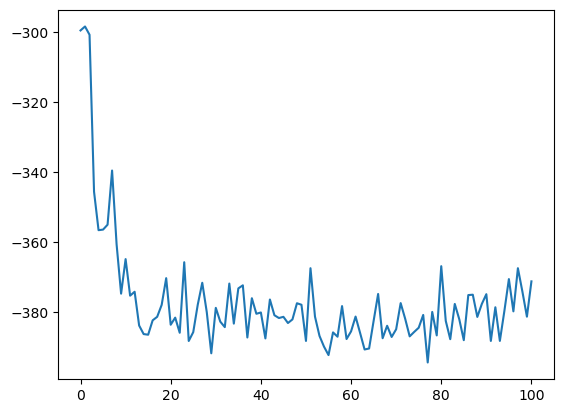

In [6]:
plt.plot(energies);

In [7]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random

import adabmDCA
from adabmDCA.utils import get_device, get_dtype, get_mask_save
from adabmDCA.sampling import get_sampler
from adabmDCA.functional import one_hot

import sys
sys.path.append('..')
import selex_dca, utils

In [8]:
experiment_id = "Dop8V030"
round_ids = ["ARN", "R01", "R02N"]

device = get_device("")
dtype = get_dtype("float32")

Running on CPU


In [9]:
import importlib
importlib.reload(sampling)

<module 'sampling' from '/home/scrotti/Aptamer2025py/sampling.py'>

In [10]:
sequences = [utils.sequences_from_file(experiment_id, round_id, device) for round_id in round_ids]

In [11]:
sequences_oh = [one_hot(seq, num_classes=q).to(dtype) for seq in sequences]

In [12]:
def init_chains(
    n_rounds: int,
    n_chains: int,
    L: int,
    q: int,
    device: torch.device,
    dtype: torch.dtype | None = None,
) -> torch.Tensor:

    if dtype is None:
        dtype = torch.float32
    chains = [torch.randint(low=0, high=q, size=(n_chains, L), device=device)
            for _ in range(n_rounds)]
    
    chains_tensor = torch.stack([one_hot(c, num_classes=q).to(dtype) for c in chains])
    
    return chains_tensor   # n_rounds, n_chains, L, q

def update_chains(chains, t, model, n_sweeps):
    compute_energy = lambda x : model.compute_energy_up_to_round(x, t-1)
    sampling.sample_metropolis_uniform_sites(chains[t], compute_energy, n_sweeps)

In [38]:
def compute_gradient_at_round(model, chains, data_batch, t):
    # this L is not physically a likelihood, more like a computational trick
    L_model = model.selection_energy_at_round(chains, t).mean() \
                    + model.compute_energy_up_to_parent_round(chains, t).mean()
    L_empirical = model.selection_energy_at_round(data_batch, t).mean() \
                    + model.compute_energy_up_to_parent_round(data_batch, t).mean()
    return L_model, L_empirical

def compute_gradient(model, L_model, L_empirical):
    params = tuple(model.parameters())

    # Compute gradients for L_model
    grad_model = torch.autograd.grad(
        outputs=L_model,
        inputs=params,
        retain_graph=True,  # Need this because we'll compute gradients again
        create_graph=False
    )
    
    # Compute gradients for L_empirical
    grad_empirical = torch.autograd.grad(
        outputs=L_empirical,
        inputs=params,
        retain_graph=False,
        create_graph=False
    )
    
    grad_total = tuple(-(gm - ge) for gm, ge in zip(grad_model, grad_empirical))
    
    with torch.no_grad():
        for p, g in zip(model.parameters(), grad_total):
            p.grad = g
            
    nL_total = - (L_model - L_empirical)

    return nL_total, grad_total, grad_model, grad_empirical

# def compute_gradient(model, L_model, L_empirical):
#     params = tuple(model.parameters())

#     grad_model, grad_empirical = torch.autograd.grad(
#         outputs=(L_model, L_empirical),
#         inputs=params,
#         retain_graph=False
#     )
    
#     grad_total = tuple(gm - ge for gm, ge in zip(grad_model, grad_empirical))
#     with torch.no_grad():
#         for p, g in zip(model.parameters(), grad_total):
#             p.grad = g
            
#     L_total = L_model - L_empirical

#     return L_total, grad_total, grad_model, grad_empirical
    
def train(
    model: selex_distribution.MultiRoundDistribution,
    data_loaders,
    chains: torch.Tensor,
    n_sweeps: int,
    lr: float,    
    max_epochs: int,
    l2reg: float = 0.0,
    # history : Dict[str, List[float]] = init_history(),
    # progress_bar: bool = True,
):
    n_rounds = len(data_loaders) 
    assert chains.shape[0] == n_rounds
    loaders = [iter(dl) for dl in data_loaders]
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=l2reg)

    def halt_condition(epochs):
        c1 = epochs > max_epochs
        return c1

    epochs = 0
    while not halt_condition(epochs):
        optimizer.zero_grad()
        L_model = L_empirical = 0
        for t in range(n_rounds):
            # update chains
            with torch.no_grad():
                update_chains(chains, t, model, n_sweeps)
            # extract batch of data from round t
            data_batch = next(loaders[t])
            # compute gradient
            L_mod, L_emp = compute_gradient_at_round(model, chains[t].clone(), data_batch, t-1)
            L_model = L_model + L_mod
            L_empirical = L_empirical + L_emp
            # TODO: compute round-wise convergence metrics

        # compute gradient
        nL_total, grad_total, grad_model, grad_empirical = compute_gradient(model, L_model, L_empirical)
        # do gradient step on params
        optimizer.step()

        epochs += 1

        print(f"Epoch: {epochs}, -L = {nL_total}")

In [39]:
batch_size = 32
n_chains = batch_size
n_sweeps = 10
lr = 0.01
model = Nst
max_epochs = 50

datasets = [data_loading.SelexRoundDataset(seq_oh) for seq_oh in sequences_oh]
data_loaders = [torch.utils.data.DataLoader(ds, batch_size=batch_size, shuffle=True) for ds in datasets]
n_rounds = len(data_loaders) 
chains = init_chains(n_rounds, n_chains, L, q, device)

In [40]:
train(model, data_loaders, chains, n_sweeps, lr, max_epochs)

Epoch: 1, -L = 18494.626953125
Epoch: 2, -L = 19465.8984375
Epoch: 3, -L = 19613.42578125
Epoch: 4, -L = 19474.67578125
Epoch: 5, -L = 19269.578125
Epoch: 6, -L = 19167.5625
Epoch: 7, -L = 19327.3984375
Epoch: 8, -L = 18730.994140625
Epoch: 9, -L = 18951.166015625
Epoch: 10, -L = 18438.86328125
Epoch: 11, -L = 18654.0390625
Epoch: 12, -L = 18404.263671875
Epoch: 13, -L = 18441.671875
Epoch: 14, -L = 18388.1015625
Epoch: 15, -L = 18176.88671875
Epoch: 16, -L = 18239.98046875
Epoch: 17, -L = 17868.873046875
Epoch: 18, -L = 17788.74609375
Epoch: 19, -L = 17780.541015625
Epoch: 20, -L = 17737.12890625
Epoch: 21, -L = 17749.74609375
Epoch: 22, -L = 17478.54296875
Epoch: 23, -L = 17599.65625
Epoch: 24, -L = 17628.87109375
Epoch: 25, -L = 17716.146484375
Epoch: 26, -L = 16822.8671875
Epoch: 27, -L = 17095.064453125
Epoch: 28, -L = 16841.09375
Epoch: 29, -L = 16838.203125
Epoch: 30, -L = 16874.9140625
Epoch: 31, -L = 17133.630859375
Epoch: 32, -L = 16788.904296875
Epoch: 33, -L = 16300.4365234